# Time Series Problem: Energy Consumption Prediction

In this project, we aim to predict energy consumption based on historical data using the **XGBoost** algorithm, which is great for time-series forecasting.

The dataset we are using contains **hourly energy consumption** data for PJME (PJM East), recorded over several years. By analyzing this time-series data, we can forecast future energy consumption trends, which could be beneficial for optimizing energy grids and improving sustainability efforts.

You can download the full dataset from [here](https://www.kaggle.com/datasets/robikscube/hourly-energy-consumption).

### What will we do?
* **Data Preprocessing**: We’ll load and clean the data, ensuring it’s ready for modeling.
* **Data Visualization**: Understand consumption patterns visually to detect trends, seasonality, or anomalies.
* **Modeling with XGBoost**: We'll use XGBoost, a popular machine learning algorithm, to predict future energy consumption.
* **Prediction Evaluation**: After making predictions, we’ll evaluate the performance using metrics like **RMSE (Root Mean Square Error)** or **MAE (Mean Absolute Error)**.

### Why is this important?
Energy consumption forecasting is crucial for:
- **Energy Grid Management**: Predicting demand to prevent overloading and ensure efficiency.
- **Cost Optimization**: Accurate forecasts help optimize energy costs for consumers and providers.
- **Sustainability**: Helps predict renewable energy needs and manage resources effectively.

By the end of this project, you’ll have a working forecast model that can predict energy consumption, as well as insights into how to improve it for future predictions. Let's dive in!




In [27]:
#importing our dependencies 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

In [28]:
#getting our dataset
df = pd.read_csv('D:\Coding Projects\Time-Series-energy-consumption-\Data\PJME_hourly.csv')
df = df.set_index('Datetime')

# Converting the index to a datetime format for proper time series operations
df.index = pd.to_datetime(df.index)

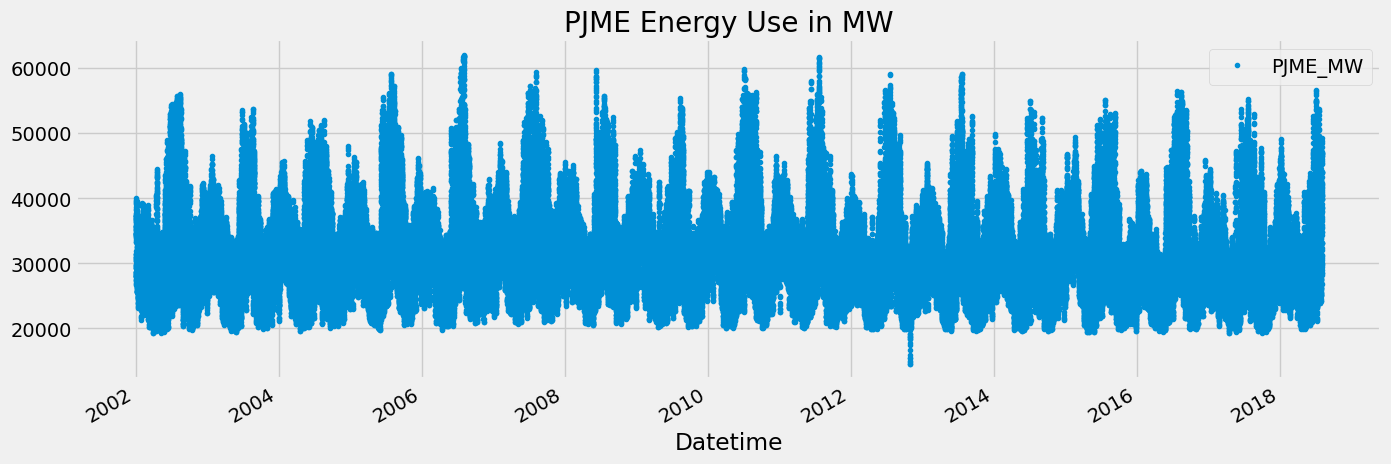

In [29]:
df.plot(style='.',  # Use dots to represent data points
        figsize=(15, 5),  # Size of the plot
        color=color_pal[0],  # Color from our palette
        title='PJME Energy Use in MW')  # Plot title

# Display the plot
plt.show()

# Test and Train Split: Preparing Data for Modeling

In this section, we’ll set up a pipeline to **train and test** our time-series model, ensuring we have the right data split for evaluating performance.

### What do we do here?
* **Data Split**: We’ll split the data into **training** and **test** sets. This allows us to train the model on historical data and test it on unseen data to assess its performance.
* **80-20 Split**: We split the data **80% for training** and **20% for testing**. This is a common practice to avoid overfitting and ensure the model generalizes well.
* **Visualization**: After splitting the data, we plot both the **training** and **testing** sets to visualize how the data looks before and after the split.

### Why is this important?
- **Model Evaluation**: We need separate datasets to evaluate the model’s ability to predict unseen data. Without this split, the model could easily memorize the training data and fail to perform well on real-world data.
- **Insightful Visualization**: Visualizing the split helps us understand the temporal relationship between training and testing data, which is essential in time series problems.

Let’s go ahead and split the data and then plot it to see the result.



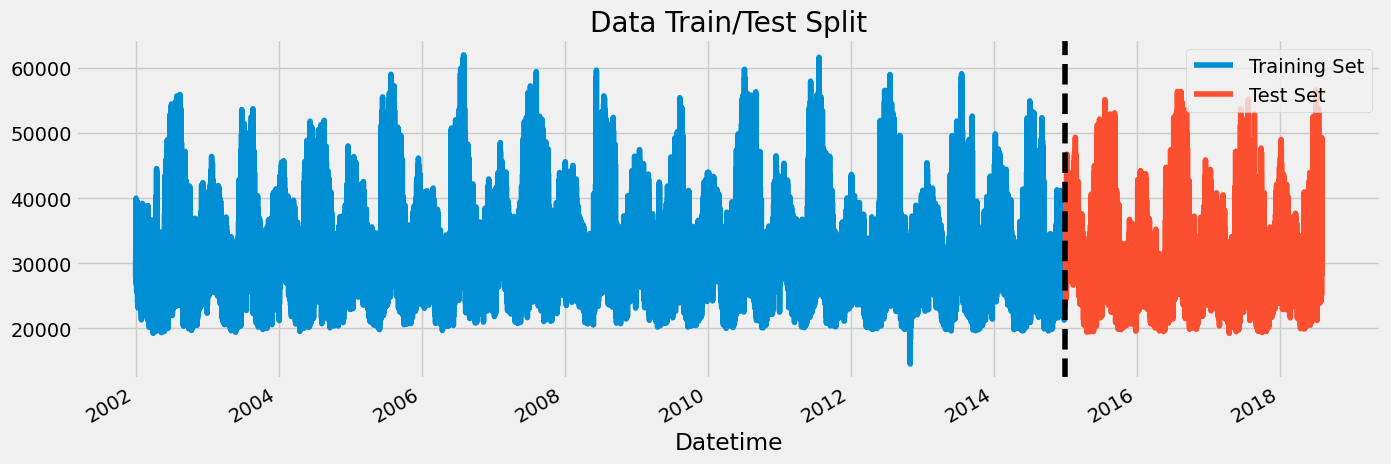

In [30]:
train = df.loc[df.index < '01-01-2015']
test = df.loc[df.index >= '01-01-2015']
# Plotting the train/test split to visualize the separation
fig, ax = plt.subplots(figsize=(15, 5))

train.plot(ax=ax, label='Training Set', title='Data Train/Test Split') # Plotting the training data
test.plot(ax=ax, label='Test Set') # Plotting the testing data
ax.axvline('01-01-2015', color='black', ls='--') # Adding a vertical line to indicate where the split occurs (January 1st, 2015)
ax.legend(['Training Set', 'Test Set'])

# Displaying the plot
plt.show()

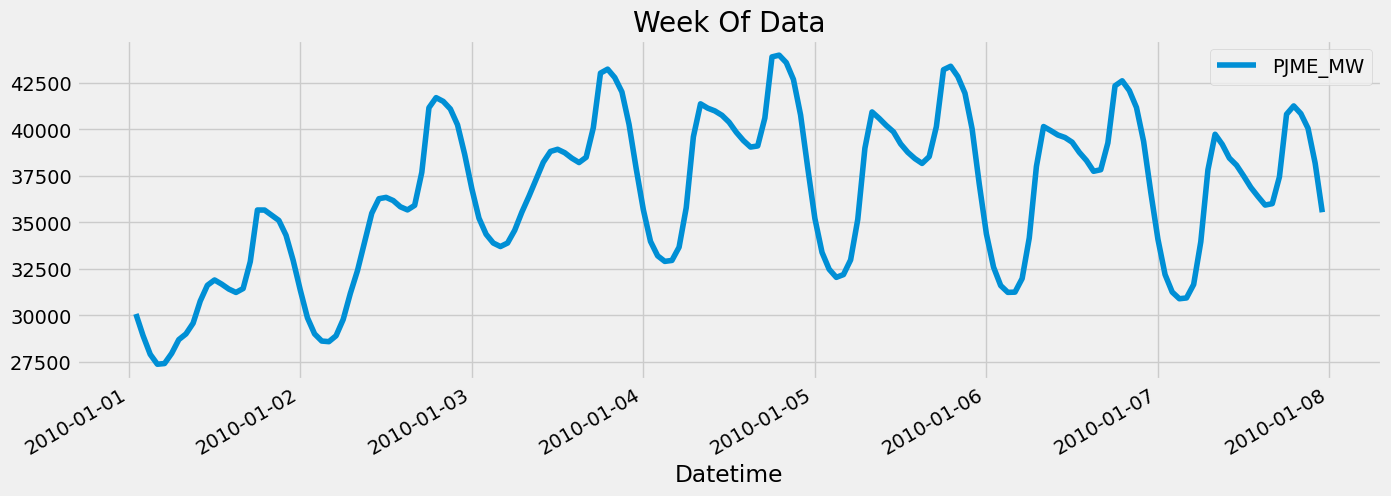

In [31]:
# Extra visualization: Viewing a specific week of data
# This plots a slice of the data from January 2010 to August 2010
df.loc[(df.index > '01-01-2010') & (df.index < '01-08-2010')] \
    .plot(figsize=(15, 5), title='Week Of Data')

# Displaying the plot of the selected week
plt.show()

# Feature Creation: Building the Right Features for Prediction

In this section, we focus on creating the **best features** to help the model make accurate predictions for our time-series problem. **Feature creation** is a crucial step in the modeling pipeline, as the right features can significantly improve model performance.

### What do we do here?
* **Time-Based Features**: Time series data often has patterns based on **time of day**, **day of the week**, **month**, and other time-related aspects. These features are created to capture these patterns.
  - **Hour of the day**
  - **Day of the week**
  - **Month of the year**
  - **Day of the year**
  - **Quarter of the year**
  - **Week of the year**
* **Visualizing Features**: Once the features are created, we visualize them to understand their distribution and check for potential patterns that can improve prediction.

### Why is this important?
- **Feature Engineering**: Well-designed features can capture important patterns in the data that a model can use to make better predictions.
- **Time Series Characteristics**: Features like **hour**, **day of the week**, and **month** help capture the cyclical nature of time, which is key in forecasting tasks like energy consumption.

Let's create the features and then visualize them to check their impact on the target variable.


In [32]:
# Function to create features based on the time index of the data
def create_features(df):
    """
    Create time series features based on the time series index.
    The function adds new columns to the dataframe that capture various time-based patterns.
    """
    df = df.copy()
    
    # Extracting different time-based features from the index
    df['hour'] = df.index.hour              # Hour of the day
    df['dayofweek'] = df.index.dayofweek    # Day of the week (0=Monday, 6=Sunday)
    df['quarter'] = df.index.quarter        # Quarter of the year (1 to 4)
    df['month'] = df.index.month            # Month of the year (1 to 12)
    df['year'] = df.index.year              # Year
    df['dayofyear'] = df.index.dayofyear    # Day of the year (1 to 365/366)
    df['dayofmonth'] = df.index.day         # Day of the month (1 to 31)
    df['weekofyear'] = df.index.isocalendar().week  # Week number of the year
    
    return df

# Create features for the dataset
df = create_features(df)

C:\Users\Amir\AppData\Local\Temp\ipykernel_13580\31792033.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='hour', y='PJME_MW', palette='rainbow')


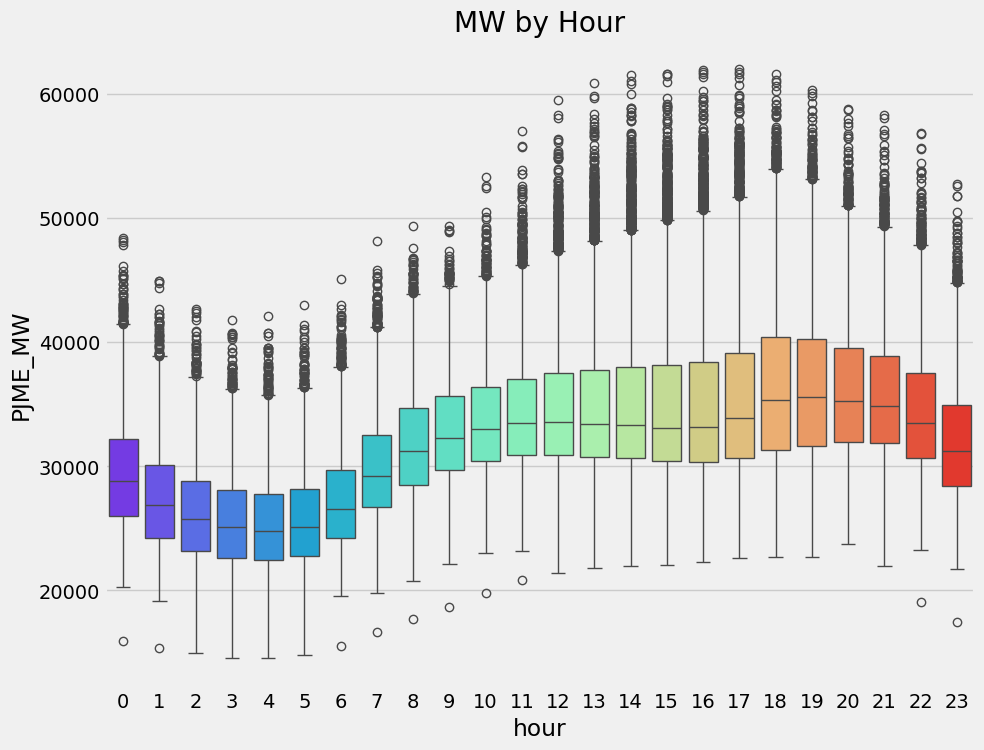

In [33]:
# Plotting MW by Hour to visualize how energy consumption varies by hour
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='PJME_MW', palette='rainbow')
ax.set_title('MW by Hour')
plt.show()

C:\Users\Amir\AppData\Local\Temp\ipykernel_13580\2108305243.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')


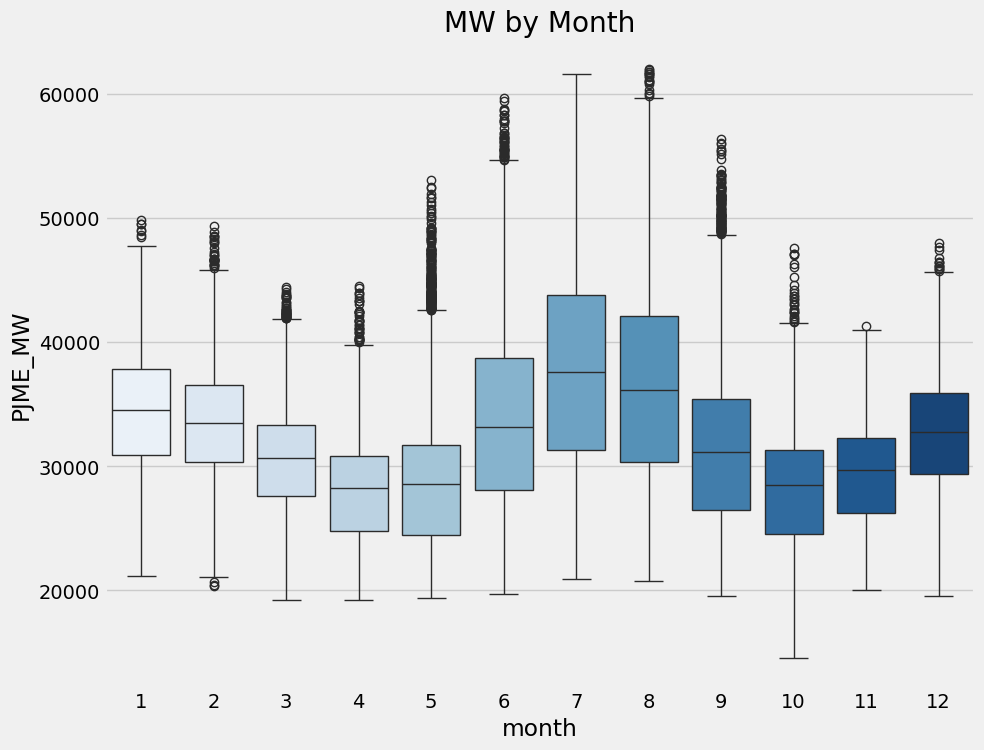

In [34]:
# Plotting MW by Month to see monthly variations in energy consumption
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='month', y='PJME_MW', palette='Blues')
ax.set_title('MW by Month')
plt.show()

# Model Creation: Building the XGBoost Model

Now that we’ve prepared our data, it’s time to create the **XGBoost model** that will tackle our time-series problem. XGBoost is a powerful machine learning algorithm, especially known for its ability to handle large datasets and its performance in regression tasks. In this section, we’ll create and train an XGBoost model to predict energy consumption based on the features we engineered earlier.

### Key Steps:
* **Data Preprocessing**: We start by applying the same feature creation process to the training and testing sets.
* **Feature and Target Setup**: We select the relevant features and define the target variable (`PJME_MW`), which represents energy consumption in megawatts.
* **XGBoost Regressor**: We create an XGBoost regressor model and train it using the training data. 
  - **Learning rate**: We set a low learning rate to ensure stable learning over many iterations.
  - **Early Stopping**: To prevent overfitting, we use early stopping to halt training when the model’s performance on the validation set doesn’t improve for 50 rounds.
* **Model Evaluation**: The model is evaluated on both the training and testing datasets to track its performance during training.

### Why XGBoost?
- **Efficient and Scalable**: XGBoost can handle large datasets with speed and accuracy.
- **Regressor for Continuous Predictions**: Since energy consumption is a continuous value, using XGBoost as a regressor helps in accurately predicting these values.

Let's now proceed to define the model, train it, and evaluate its performance.


In [35]:
# Apply feature creation to both training and test sets
train = create_features(train)
test = create_features(test)

# Define the features and target variable for training and testing
FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month', 'year']
TARGET = 'PJME_MW'

X_train = train[FEATURES]  # Features for training
y_train = train[TARGET]    # Target variable for training

X_test = test[FEATURES]    # Features for testing
y_test = test[TARGET]      # Target variable for testing

In [36]:
# Initialize the XGBoost Regressor model with key parameters
reg = xgb.XGBRegressor(
    base_score=0.5,            # Initial prediction score
    booster='gbtree',          # Tree booster for regression tasks
    n_estimators=1000,         # Number of boosting rounds (trees)
    early_stopping_rounds=50,  # Stop training after 50 rounds of no improvement
    objective='reg:linear',    # Linear regression objective for continuous target
    max_depth=3,               # Maximum depth of each tree
    learning_rate=0.01         # Learning rate to control model updates
)

# Train the model with the training data and validate with the testing data
reg.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_test, y_test)],  # Evaluate on both train and test data
    verbose=100   # Print progress every 100 iterations
)

[0]	validation_0-rmse:32605.13970	validation_1-rmse:31657.15729


C:\Users\Amir\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\core.py:160: UserWarning: [18:52:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:12584.35462	validation_1-rmse:11747.28803
[200]	validation_0-rmse:5837.33066	validation_1-rmse:5363.58554
[300]	validation_0-rmse:3923.28511	validation_1-rmse:4020.48045
[400]	validation_0-rmse:3447.54638	validation_1-rmse:3860.60088
[500]	validation_0-rmse:3288.19208	validation_1-rmse:3816.37862
[600]	validation_0-rmse:3206.55619	validation_1-rmse:3779.04119
[700]	validation_0-rmse:3153.61368	validation_1-rmse:3754.45684
[800]	validation_0-rmse:3114.34038	validation_1-rmse:3738.38209
[900]	validation_0-rmse:3084.39550	validation_1-rmse:3730.01893
[988]	validation_0-rmse:3060.25324	validation_1-rmse:3728.07396


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=1000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

# Feature Importance: Understanding Key Variables

Once we have trained our model, the next step is to understand which features are contributing the most to the model's predictions. This is where **feature importance** comes into play. 

### Why Feature Importance?
- **Identifying Influential Features**: Knowing which features have the greatest impact allows us to focus on optimizing them or even removing the least important ones.
- **Model Interpretability**: Understanding the importance of each feature helps us interpret the model’s decision-making process.
- **Data Optimization**: By recognizing the key features, we can improve the model by focusing on the variables that matter most.

We will visualize the feature importance by plotting the importance of each feature from our XGBoost model.

### Key Steps:
- **Feature Importance Extraction**: Using the trained model, we extract the feature importance scores.
- **Visualization**: We visualize these scores using a horizontal bar chart, which makes it easier to compare the importance of each feature.

Let’s take a look at which features are driving our energy consumption predictions the most.


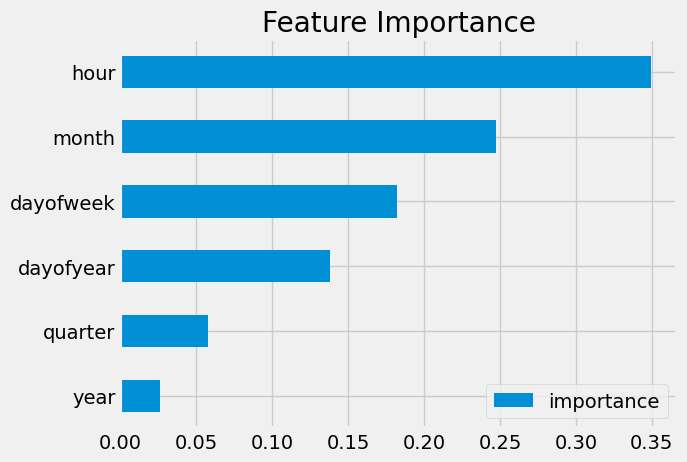

In [37]:
# Extract feature importances from the trained model
fi = pd.DataFrame(
    data=reg.feature_importances_,  # The importance of each feature
    index=reg.feature_names_in_,    # Feature names used in the model
    columns=['importance']          # Label the importance column
)

# Sort the features by importance and plot them as a horizontal bar chart
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()


# Forecast: Making Predictions

With our trained XGBoost model in place and a solid understanding of the key features (hour, month, day of week, and day of year), it's time to see how well our model can forecast energy consumption.

### Steps to Forecast:
1. **Make Predictions**: We will use the trained model to predict the energy consumption for our test data.
2. **Store Predictions**: After generating the predictions, we will store them in our dataset for easy comparison and visualization.
3. **Visualize Results**: By comparing the predicted data to the actual observed data, we can evaluate how well our model is performing.

### Why Forecasting Matters:
- **Model Evaluation**: By comparing predictions with actual data, we can visually inspect the accuracy of our model.
- **Understanding Model Behavior**: Seeing the forecasted values against the actual values helps us understand how the model is performing over different time periods.
- **Real-World Application**: In real-world applications, this kind of forecasting could be critical for energy demand prediction, allowing utilities to plan accordingly.

Now, let’s take a look at how well our model predicts energy consumption.


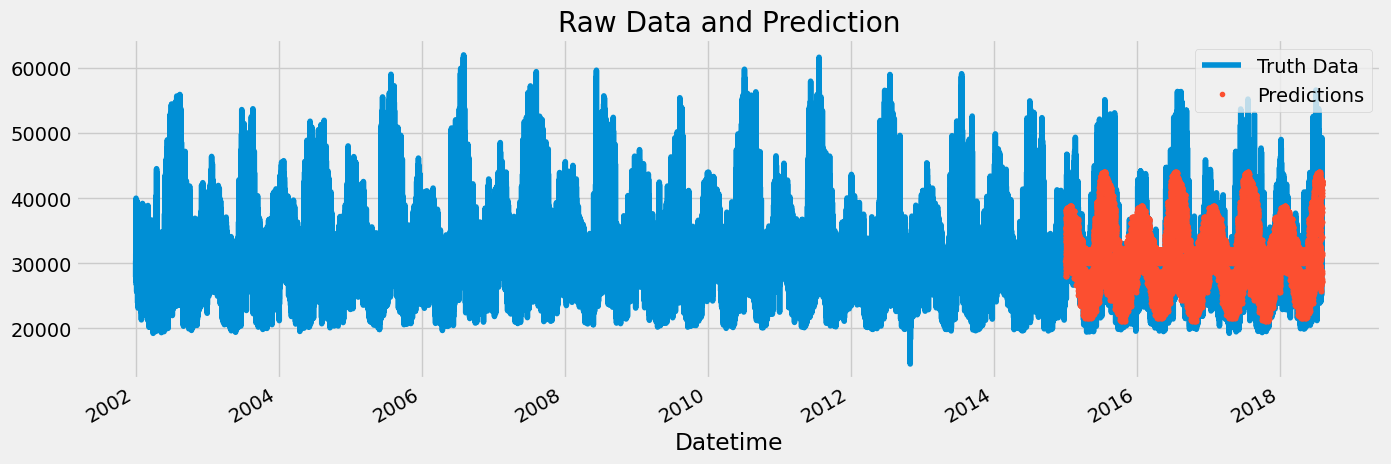

In [38]:
# Make predictions using the trained model on the test data
test['prediction'] = reg.predict(X_test)

# Merge the predicted values into the original dataframe
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)

# Plot the actual energy consumption and predicted values
ax = df[['PJME_MW']].plot(figsize=(15, 5))  # Plot the actual energy consumption
df['prediction'].plot(ax=ax, style='.')     # Plot the predicted energy consumption
plt.legend(['Truth Data', 'Predictions'])   # Add a legend
ax.set_title('Raw Data and Prediction')     # Set the title for the plot
plt.show()

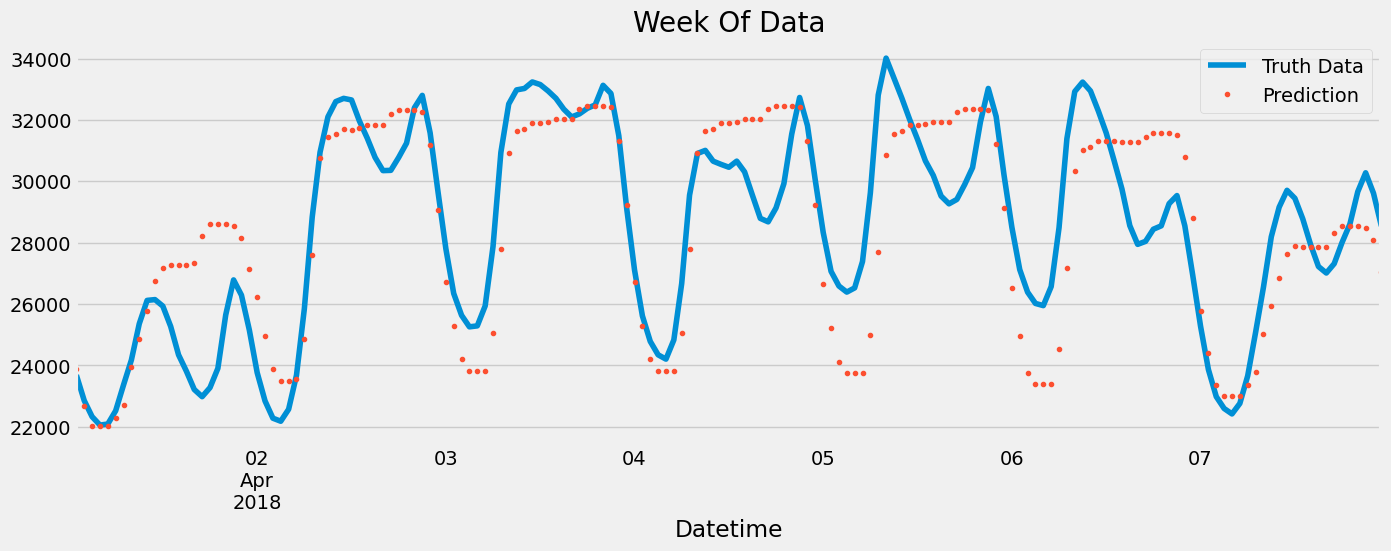

In [39]:
# Zoom in on a specific week of data for a more detailed view
ax = df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['PJME_MW'] \
    .plot(figsize=(15, 5), title='Week Of Data')  # Plot the actual energy consumption for the week
df.loc[(df.index > '04-01-2018') & (df.index < '04-08-2018')]['prediction'] \
    .plot(style='.')  # Plot the predicted energy consumption for the same week
plt.legend(['Truth Data','Prediction'])  # Add a legend
plt.show()

# Scoring Our Model: Evaluating Performance

In this section, we assess the effectiveness of our model by calculating the **Root Mean Squared Error (RMSE)** and examining the prediction errors over time.

### Why Scoring Matters:
- **Model Evaluation**: The RMSE score helps us understand how well our model's predictions match the actual values. A lower RMSE means better performance.
- **Error Analysis**: By analyzing the prediction errors, we can gain insights into where and when the model struggles the most.
- **Improvement Opportunities**: Understanding the error distribution helps identify areas where the model can be fine-tuned, such as certain hours, days, or months with higher prediction errors.

Let’s start by calculating our model’s score and examining its prediction errors.


In [40]:
# Calculate the Root Mean Squared Error (RMSE) for the model's predictions
score = np.sqrt(mean_squared_error(test['PJME_MW'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')  # Output the RMSE score for the test set

RMSE Score on Test set: 3726.80


In [41]:
# Calculate the absolute error between the actual and predicted values
test['error'] = np.abs(test[TARGET] - test['prediction'])

# Add a 'date' column for easier grouping by date
test['date'] = test.index.date

# Group the errors by date and find the top 10 dates with the highest average error
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(15)

date
2016-08-13    12879.484619
2016-08-14    12772.887207
2015-02-20    11186.031494
2016-09-09    10966.513102
2016-09-10    10889.102214
2018-01-06    10642.975830
2016-08-12    10041.172689
2015-02-21     9988.168783
2015-02-16     9900.809326
2018-01-07     9852.571370
2015-02-15     9482.349284
2017-05-19     9351.232992
2017-12-31     9224.555990
2018-01-05     9078.928955
2016-07-04     9057.563395
Name: error, dtype: float64

# Conclusion

In this project, we created a basic **XGBoost model** to predict energy consumption based on historical data. The model was able to successfully make predictions on the test set, which is a good starting point. 

### Key Takeaways:
- **Model Performance**: While the model performed well enough to make predictions, it didn’t achieve optimal performance.
- **RMSE Score**: The **Root Mean Squared Error (RMSE)** score suggests that there’s room for improvement in the accuracy of predictions. Lowering this score will help improve the reliability of the model.
- **Feature Refinement**: To improve the model further, we could experiment with **adding more important features**, ensuring the model has all the necessary information to make accurate predictions.

### Future Improvements:
- **Fine-tuning the Model**: Adjusting hyperparameters such as **learning rate** or **max_depth** can help optimize the model.
- **Feature Engineering**: Adding additional time-based features or external data sources could enhance the model's understanding of the energy consumption patterns.
- **Model Enhancement**: Exploring more complex models or integrating additional ensemble methods could also be valuable next steps.

This model is a good starting point, and with further refinements, it can become more accurate and robust in forecasting energy consumption.
